In [25]:
%matplotlib inline

%load_ext autoreload
%autoreload 1

import numpy as np
import matplotlib.pyplot as plt

%aimport detectors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/drsmith/opt/miniconda3/lib/python3.9/site-packages/numpy/core/function_base.py:277: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


# Diodes and noise

Photodiodes convert incident radiant flux $P_{inc}$ into a photocurrent $I_{ph}$:

$$I_{ph} = G\cdot R\cdot P_{inc}\quad[A]$$

where $G$ is diode gain, $R$ is diode responsivity in $A/W$ and $P_{inc}$ is the indicdent radiant flux in $W$.  The diode responsivity $R$ is related to the diode quantum efficiency $QE$:

$$R = QE\cdot\frac{\lambda[nm]}{1240}\quad[A/W]$$

PIN diodes have gain $G=1$, and APDs have $G>1$ (typ. 50-100).

Photodiodes are susceptible to shot noise and thermal noise, and APDs additionally are susceptible to "excess noise".  The excess noise is characterized by the excess noise factor $F\ge 1$.  APDs have $F>1$, and to unify notation, PIN diodes conceptualy have $F=1$.  PIN diode and APD noise sources:
- Shot noise from photocurrent and dark (leakage) current
  - APDs have volume dark current that is subject to gain and excess noise and surface dark current that is not subject to gain and excess noise
  - Shot noise from the photocurrent is the irreducible minimum noise, and it is often known as the "photon noise limit"
- Thermal (Johnson) noise from diode shunt resistance
  - Negligible for APDs; likely negligible for PIN diodes
- APD only: Excess noise factor
  - A multiplicitive factor on shot noise terms

All of the above noise sources are white noise with a flat frequency spectrum.  (As discussed below, the diode junction capacitance contributes to the "ENC" or channel noise in the JFET and TIA.)  Noise sources are expressed in terms of current noise power density (CNPD), denoted by $i^2$ with units $A^2/Hz$.  When expressed as a power density, noise sources are additive:

$$i^2_{total} = i^2_1 + i^2_2 + i^2_3\cdots$$

Noise current $i^2$ may be frequency independent (flat, white noise) or frequency dependent.  Shot noise and thermal noise are flat, but "ENC" noise discussed below is frequency dependent.  For flat noise sources, the RMS noise current is

$$I_{noise,rms}=\sqrt{i^2_{total} * B}\quad[A]$$

where $B$ is the bandwidth in $Hz$.  More generally, for frequency dependent noise sources, the RMS noise current is

$$I_{noise,rms}=\sqrt{\int i^2_{total}(\omega)\,d\omega}\quad[A]$$

The *instantaineous* signal-to-noise ratio $SNR$ is

$$SNR = \frac{I_{ph}}{I_{noise,rms}}$$

The frequency-resolved noise floor is lower than indicated by the instantaineous $SNR$ due to time averaged statistics.

# Define diodes

In [49]:
diodes = {
    'API_C164_PIN' : detectors.PinDiode(
        name='AP PDB-C164 PIN',
        responsivity=0.43,  # A/W @ 650 nm
        darkcurrent_ref=1e-9,  # typ 1 nA, max 10 nA @ T=20C
        junction_cap_ref=7e-12,  # typ 7 pF @ Vr=10V
        vb_ref=10,  # reference bias voltage for junction cap.
        r_shunt=500e6,  # shunt resistance
    ),
    'Hama_S13620_PIN' : detectors.PinDiode(
        name='Hama. S13620 8x8 PIN',
        responsivity=0.49,  # A/W @ 650 nm
        darkcurrent_ref=0.3e-9,  # typ 10 pA, max 300 pA @ Vr=10mV, T=20C
        junction_cap_ref=15e-12,  # typ 15 pF @ Vr=8.6V
        vb_ref=8.6,
    ),
    'Hama_S8550_APD' : detectors.ApdDiode(
        name='Hama. S8550 4x8 APD',
        qe=0.85,  # QE @ 650 nm
        gain=50,  # gain @ Vr=330 V
        darkcurrent_ref=1e-9,  # typ 1 nA, max 10 nA @ Vr=330V, M=50
        junction_cap_ref=9e-12,  # typ 9 pF @ Vr=330V, M=50
        noise_figure=0.2,
        vb_ref=330,  # reference bias for gain and junction cap.
    ),
}

AP PDB-C164 PIN
  QE = 81.3 %
  Resp. = 0.43 A/W
  Dark current (total or vol.) = 1.000 nA
Hama. S13620 8x8 PIN
  QE = 92.6 %
  Resp. = 0.49 A/W
  Dark current (total or vol.) = 0.300 nA
Hama. S8550 4x8 APD
  QE = 85.0 %
  Resp. = 0.45 A/W
  Dark current (total or vol.) = 1.000 nA
  Noise factor = 1.050


/Users/drsmith/opt/miniconda3/lib/python3.9/site-packages/numpy/core/function_base.py:277: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


# Diode noise plots

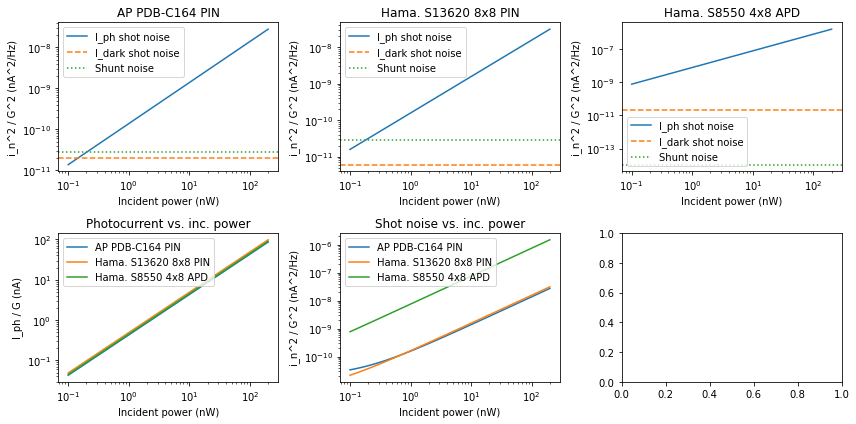

In [53]:
ncols, nrows = 3, 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*4, nrows*3))
p_inc = np.geomspace(0.1,200)  # incident power [nW]

t_def = -20

iplot=0
for diode in diodes.values():
    plt.sca(axes.flat[iplot])
    plt.loglog(p_inc, 
        diode.photocurrent_shot_noise_CNPD(p_inc) / diode.gain**2 * 1e18,
        label='I_ph shot noise', c='C0')
    plt.axhline(diode.dark_current_shot_noise_CNPD(t=t_def) / diode.gain**2 * 1e18,
        label='I_dark shot noise', ls='--', c='C1')
    plt.axhline(diode.shunt_noise_CNPD(t=t_def) / diode.gain**2 * 1e18,
        label='Shunt noise', ls=':', c='C2')
    plt.xlabel('Incident power (nW)')
    plt.ylabel('i_n^2 / G^2 (nA^2/Hz)')
    plt.title(diode.name)
    plt.legend()
    iplot += 1

# photocurrent vs. inc. power
plt.sca(axes.flat[iplot])
for diode in diodes.values():
    plt.loglog(p_inc, 
        diode.photocurrent(p_inc)/diode.gain*1e9,
        label=diode.name)
plt.xlabel('Incident power (nW)')
plt.ylabel('I_ph / G (nA)')
plt.title('Photocurrent vs. inc. power')
plt.legend()
iplot +=1

# noise vs. inc. power
plt.sca(axes.flat[iplot])
for diode in diodes.values():
    shot_noise_CNPD = diode.photocurrent_shot_noise_CNPD(p_inc, ideal=False) + \
        diode.dark_current_shot_noise_CNPD(t=t_def, ideal=False)
    plt.loglog(p_inc,
        shot_noise_CNPD / diode.gain**2 * 1e18,
        label=diode.name)
plt.xlabel('Incident power (nW)')
plt.ylabel('i_n^2 / G^2 (nA^2/Hz)')
plt.title('Shot noise vs. inc. power')
plt.legend()
iplot+=1

plt.tight_layout()

Calculation parameters:
  Bandwidth = 1.00 MHz
  Temperature = -20.0 C
  Shunt resistance = 100.0 MOhms

In currents plot, shunt noise is black, shot nosie is solid, and photocurrent is dashed


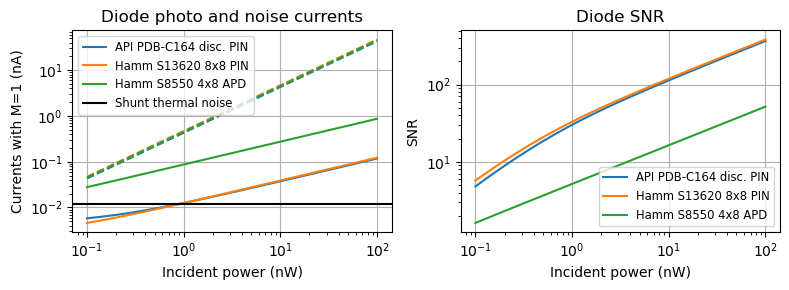

In [33]:
# diodes = detectors.diodes

p_incident = np.geomspace(0.1,100)  # incident pwoer on log scale [nW]
bw = 1e6
t = -20

print('Calculation parameters:')
print(f'  Bandwidth = {bw/1e6:.2f} MHz')
print(f'  Temperature = {t:.1f} C')
print(f'  Shunt resistance = {r_shunt/1e6:.1f} MOhms')

print('\nIn currents plot, shunt noise is black, shot nosie is solid, and photocurrent is dashed')

ncol=2
nrow=1
fig, axes = plt.subplots(nrow, ncol, figsize=(4*ncol,3*nrow), dpi=100)
for i, diode in enumerate(diodes.values()):
    plt.sca(axes.flat[0])
    plt.plot(p_incident, diode.photocurrent(p_inc=p_incident)*1e9/diode.gain, 
        '--', color=f'C{i}')
    plt.plot(p_incident, diode.shot_noise_current(p_inc=p_incident, bw=bw, t=t)*1e9/diode.gain, 
        '-', label=diode.name, color=f'C{i}')
    if i==len(diodes)-1:
        plt.axhline(diode.shunt_noise_current(t=t, bw=bw, r_shunt=r_shunt)*1e9,
            color='k', label='Shunt thermal noise')
    plt.title('Diode photo and noise currents')
    plt.ylabel('Currents with M=1 (nA)')
    plt.sca(axes.flat[1])
    plt.plot(p_incident, diode.SNR(p_inc=p_incident, bw=bw, t=t), 
        label=diode.name, color=f'C{i}')
    plt.title('Diode SNR')
    plt.ylabel('SNR')
for ax in axes.flat:
    plt.sca(ax)
    plt.grid(True)
    plt.xlabel('Incident power (nW)')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(fontsize='small')
plt.tight_layout()

# Transimpedance amplifier (TIA)

TIA current noise sources

- Shot noise from FET gate current
- Thermal (Johnson) noise from feedback resistor
- Current noise from TIA voltage noise and input capacitance
  - Input capacitance includes diode junction cap., FET cap., and board stray cap.